In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

### galactic ###

In [2]:
energy_grid = np.logspace(1,5,51) #in GeV
m_chi= 1000 #in GeV
J_allsky=2.3e23 #from Carlos

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [4]:
def dNdE_nu(m_chi, E):
    tmp = np.zeros_like(E)
    # Since we work on a grid, the delta function is the closest val
    idE = find_nearest(E, m_chi) - 1
    tmp[idE] = 2 / E[idE]
    return tmp

In [5]:
# flux=dNdE_nu(m_chi,energy_grid)
# plt.plot(energy_grid,flux)
# plt.xscale("log")

In [6]:
# def J(theta):
#     #add intepr line
#     return

In [7]:
def galactic_flux(E, m_chi, sv, J):
        """ Fetches the galactic flux
        E : Energy Grid
        m_x : Dark Matter mass
        sv : signma_nu
        k : k factor (majorana: 2 otherwise 4)
        J : J-factor
        """
        k=2
        return (1 / (4 * np.pi)) * (sv / (3 * k * m_chi**2)) * J * dNdE_nu(m_chi, E)

### extra-galactic ###

In [8]:
omega_m=0.25
omega_L=0.75
omega_r=4.75e-5
omega_dm = 0.23
h=0.67
rho_c=1.053e-5 * h**2 #GeV/cm^3
massOfSun_grid=np.logspace(-9, 17, 151)

In [9]:
def a_z(z):
    return 1 / (1+z)

In [10]:
def H_z(z):
    a=a_z(z)
    H_0= 70/3.086e19 #km/s/Mpc->
    return H_0* ((omega_m/a**3) + omega_L)**(1/2)

In [11]:
def omega_mz(z):
    a = a_z(z)
    return  (omega_m/a**3) / (omega_L + omega_m/a**3 )

In [12]:
def omega_Lz(z):
    a = a_z(z)
    return  (omega_L) / (omega_L + omega_m/a**3)

### lopez parametrization ###

In [13]:
def D_prada(z):
    a=a_z(z)
    x_values=(omega_L/omega_m)**(1/3) * a_z(z)
    D_result=[]
    if isinstance(x_values,float):
        x=x_values
        prefactor = np.sqrt(1+x**3)/x**(3/2)
        D= lambda x: x**(3/2)/(1+x**3)**(3/2)
        x_int = integrate.quad(D,0, x)
        result = (5/2)*(omega_L/omega_m)**(1/3)*prefactor* x_int[0]
        D_result.append(result)
    elif len(x_values)>= 1:
        for x in x_values:
            prefactor = np.sqrt(1+x**3)/x**(3/2)
            D= lambda x: x**(3/2)/(1+x**3)**(3/2)
            x_int = integrate.quad(D,0, x)
            result = (5/2)*(omega_L/omega_m)**(1/3)*prefactor* x_int[0]
            D_result.append(result)
    else:
        print('error!')
    return np.array(D_result)

In [14]:
def D_lopez(z):
    return (5/2)*omega_mz(z) / (omega_mz(z)**(4/7)-omega_Lz(z)+(1+omega_mz(z)/2)*(1+omega_Lz(z)/70)) /(1+z)

In [15]:
#D_lopez(1),D_prada(1)

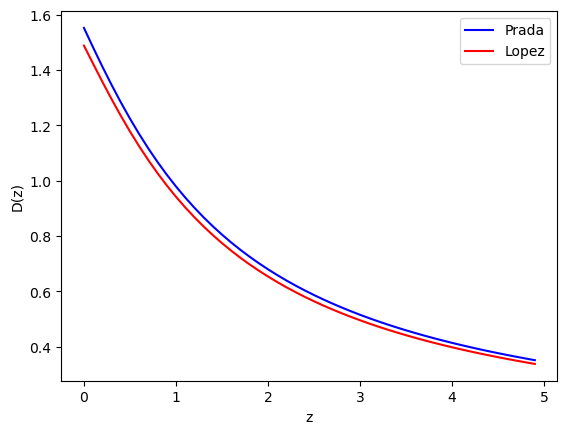

In [16]:
z_grid=np.arange(0,5,0.1)
plt.plot(z_grid,D_prada(z_grid),'b-',label="Prada")
plt.plot(z_grid,D_lopez(z_grid)*2,'r-',label="Lopez")
plt.xlabel('z')
plt.ylabel('D(z)')
plt.legend()

In [17]:
#lopez eq.B15 convert M 10^[-9,17]
def sigma_lopez(M):
    return np.exp((2.6 * M**(0.001745)) - 0.2506 * M**0.07536)

#lopez eq.B15
def ln_inv_sigma_lopez(M):
    return 2.6 * M**0.001745 - 0.2506 * M**0.07536

In [18]:
#prada eq.23, M 10^[10-15]
def sigma_prada(M):
    y = (M*h/1e12)**(-1)
    return 16.9*(y**0.41)/(1 + 1.102*(y**0.2) + 6.22*(y**0.333))

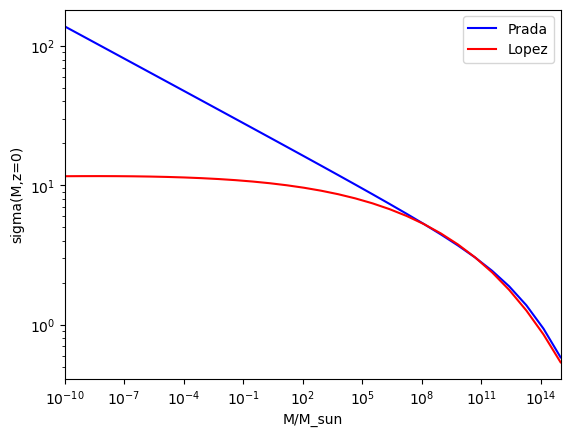

In [19]:
massOfSun_grid=np.logspace(-10, 15, 30)
plt.plot(massOfSun_grid,sigma_prada(massOfSun_grid),'b-',label="Prada")
plt.plot(massOfSun_grid,sigma_lopez(massOfSun_grid),'r-',label="Lopez")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('M/M_sun')
plt.ylabel('sigma(M,z=0)')
plt.xlim([1e-10,1e15])
#plt.ylim([1e-1,1e1])
plt.legend()

In [20]:
#c_200 and lnsigma(z=0) comparison of lopez/prada/ibarra
def sigma_final_lopez(M,z):
    return sigma_lopez(M)*D_lopez(z)/D_lopez(0)

def sigma_quote_lopez(M,z):
    return B_1(z)*sigma_final_lopez(M,z)


In [21]:
def c_200_prada(M,z):
    return B_0(z)*C_sigma_quote_prada(M,z)

def c_200_lopez(M,z):
    return B_0(z)*C_sigma_quote_lopez(M,z)

In [22]:
def C_sigma_quote_prada(M,z):
    quote = sigma_quote_prada(M,z)
    A = 2.881
    b = 1.257
    c = 1.022
    d = 0.060
    return A * ((quote / b)**c + 1) * np.exp(d / quote**2)

def C_sigma_quote_lopez(M,z):
    quote = sigma_quote_lopez(M,z)
    A = 2.881
    b = 1.257
    c = 1.022
    d = 0.060
    return A * ((quote / b)**c + 1) * np.exp(d / quote**2)

In [23]:
def sigma_quote_prada(M,z):
    return B_1(z)*sigma_final_prada(M,z)

def sigma_final_prada(M,z):
    return sigma_prada(M)*D_prada(z)

In [24]:
def sigma_inv_min(x):
    sigma_inv_0 = 1.047
    sigma_inv_1 = 1.646
    beta = 7.386
    x_1 = 0.526
    return sigma_inv_0 + (sigma_inv_1 - sigma_inv_0) * ((np.arctan(beta * (x - x_1)) / np.pi) + (1/2))

def B_1(z):
    a=a_z(z)
    x=(omega_L/omega_m)**(1/3) * a_z(z)
    return sigma_inv_min(x)/sigma_inv_min(1.393)

In [25]:
def c_min(x):
    c0 = 3.681
    c1 = 5.033
    alpha = 6.948
    x_0 = 0.424
    return c0 + (c1 - c0) * ((np.arctan(alpha * (x - x_0)) / np.pi) + (1/2))

def B_0(z):
    a=a_z(z)
    x=(omega_L/omega_m)**(1/3) * a_z(z)
    return c_min(x)/c_min(1.393)

In [26]:
def ln_sigma_inv_lopez(M):
    return 0.2506 * M**(0.07536) - 2.6 * M**0.001745

In [27]:
def ln_sigma_inv_prada(M):
    return np.log((sigma_final_prada(M,z=0))**(-1))

In [28]:
#ibarra c
#conservative estimation between M_200 mas and M_vir mass
def c_ibarra(M_vir,z,M_to_Mvir=1.2):
    w =0.029
    m =0.097
    a = w*z-m
    alpha= -110.001
    beta=2469.720
    gamma=16.885
    b = alpha/(z+gamma)+beta/(z+gamma)**2
    M_200_grid = M_vir *M_to_Mvir
    return 10**(a*np.log10(M_200_grid*h)+b)

In [29]:
#multidark c,look into table, only test z=0 case
def c_200_multidark(M,z):
    z=0
    C_0=7.40
    gamma=0.120
    M_0=5.5e12 * 1e12/ h #include mass of sun
    return C_0 *(M*h/1e12)**(-gamma)*(1+(M/M_0)**0.4)

### compare c(M,z)-M relationship ###

In [30]:
#for later vector multiplication, the two array must have same length
massOfSun_grid=np.logspace(-10, 16, 42)
z_grid=np.linspace(0,5,42)

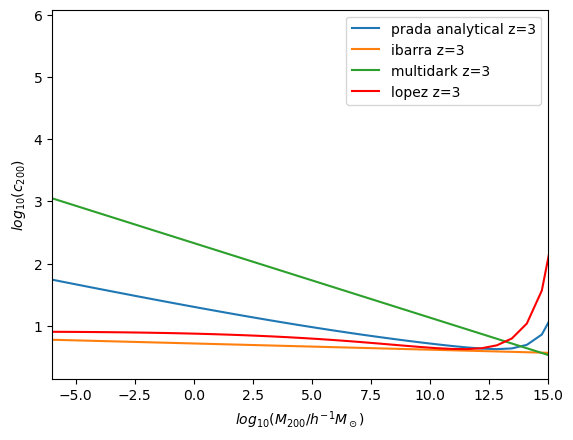

In [31]:
z_0_grid=np.linspace(0,0,42)
z_1_grid=np.linspace(1,1,42)
z_2_grid=np.linspace(2,2,42)
z_3_grid=np.linspace(3,3,42)
#plt.plot(ln_sigma_inv_lopez(massOfSun_grid),c_200(massOfSun_grid,z_zero_grid,sigma_quote_lopez),'b-',label='lopez')
#plt.plot(ln_sigma_inv_prada(massOfSun_grid),c_200(massOfSun_grid,z_zero_grid,sigma_quote_prada),'r-',label='prada')
#plt.plot(np.log10((sigma_prada(massOfSun_grid))**(-1)),c_200_prada(massOfSun_grid,z_0_grid),'r-',label='prada')
#plt.plot(np.log10((sigma_prada(massOfSun_grid))**(-1)),c_200_prada(massOfSun_grid,z_1_grid),'r-',label='prada')
#plt.plot(np.log10((sigma_prada(massOfSun_grid))**(-1)),c_200_prada(massOfSun_grid,z_2_grid),'r-',label='prada')
#plt.plot(np.log10((sigma_prada(massOfSun_grid))**(-1)),c_200_prada(massOfSun_grid,z_3_grid),'r-',label='prada')
#plt.plot(massOfSun_grid,ln_sigma_inv_prada(massOfSun_grid),'r-',label='prada')
plt.plot(np.log10(massOfSun_grid),np.log10(c_200_prada(massOfSun_grid,z_3_grid)),'-',label='prada analytical z=3')
#plt.plot(np.log10(massOfSun_grid),np.log10(c_200_prada(massOfSun_grid,z_1_grid)),'-',label='prada z=1')
#plt.plot(np.log10(massOfSun_grid),np.log10(c_200_prada(massOfSun_grid,z_2_grid)),'-',label='prada z=2')
#plt.plot(np.log10(massOfSun_grid),np.log10(c_200_prada(massOfSun_grid,z_3_grid)),'-',label='prada z=3')
plt.plot(np.log10(massOfSun_grid),np.log10(c_ibarra(massOfSun_grid,z_3_grid)),'-',label='ibarra z=3')
plt.plot(np.log10(massOfSun_grid),np.log10(c_200_multidark(massOfSun_grid,z_3_grid)),'-',label='multidark z=3')
plt.plot(np.log10(massOfSun_grid),np.log10(c_200_lopez(massOfSun_grid,z_3_grid)),'r-',label='lopez z=3')
plt.xlabel(r'$log_{10} (M_{200}/h^{-1} M_\odot)$')
plt.ylabel(r'$log_{10}(c_{200})$')
plt.xlim([-6,15])
#plt.ylim([0.5,1.2])
plt.legend()

In [32]:
def g_tild(M,z,c_200_function):
    c_200=c_200_function(M,z)
    return ((c_200**3) * (1 - (1 + c_200)**(-3))) / (3 * (np.log(1 + c_200) - c_200 * (1 + c_200)**(-1))**2)

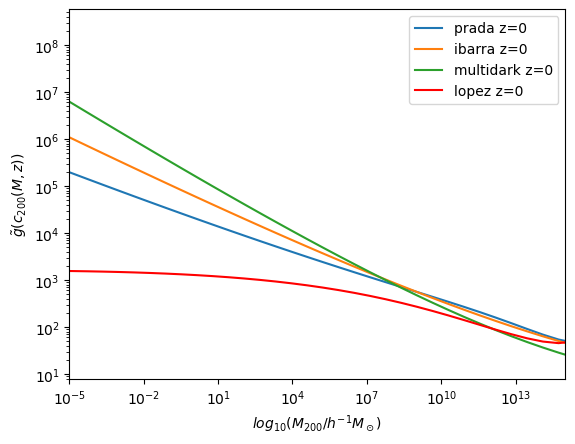

In [33]:
z_0_grid=np.linspace(0,0,42)
z_1_grid=np.linspace(1,1,42)
z_2_grid=np.linspace(2,2,42)
z_3_grid=np.linspace(3,3,42)
plt.plot(massOfSun_grid,g_tild(massOfSun_grid,z_0_grid,c_200_prada),'-',label='prada z=0')
plt.plot(massOfSun_grid,g_tild(massOfSun_grid,z_0_grid,c_ibarra),'-',label='ibarra z=0')
plt.plot(massOfSun_grid,g_tild(massOfSun_grid,z_0_grid,c_200_multidark),'-',label='multidark z=0')
plt.plot(massOfSun_grid,g_tild(massOfSun_grid,z_0_grid,c_200_lopez),'r-',label='lopez z=0')
plt.xlabel(r'$log_{10} (M_{200}/h^{-1} M_\odot)$')
plt.ylabel(r'$\tilde{g}(c_{200}(M,z))$')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-5,1e15])
#plt.ylim([0, 0.5e8])
plt.legend()

In [34]:
def f_178(sigma_function,M,z):
    sigma=sigma_function(M,z)
    A = omega_mz(z)*(1.097*(1+z)**(-3.216) + 0.074)
    alpha = omega_mz(z)*(5.907*(1+z)**(-3.599) + 2.344)
    beta = omega_mz(z)*(3.136*(1+z)**(-3.068) + 2.349)
    gamma = 1.318
    
    return A * ((sigma / beta)**(-alpha) + 1) * np.exp(-gamma / sigma**2)

In [35]:
def f_delta(sigma_function,M,z):
    delta=200
    sigma=sigma_function(M,z)
    return (np.exp(((delta / 178) - 1) * (0.023 - (0.072 / sigma**2.13))) *
            (delta / 178)**(-0.456 *omega_mz(z) - 0.139))* f_178(sigma_function,M,z)

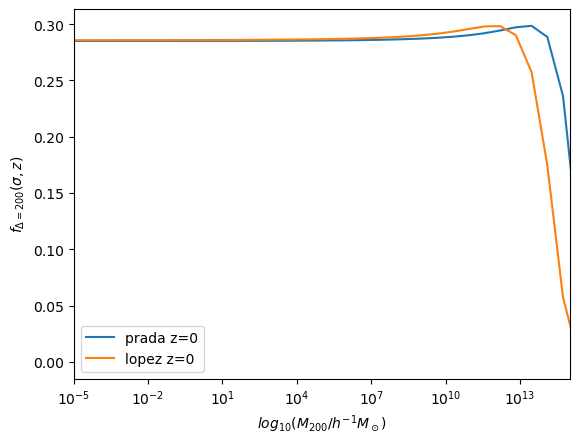

In [36]:
z_0_grid=np.linspace(0,0,42)
z_1_grid=np.linspace(1,1,42)
z_2_grid=np.linspace(2,2,42)
z_3_grid=np.linspace(3,3,42)
plt.plot(massOfSun_grid,f_delta(sigma_final_prada,massOfSun_grid,z_0_grid),'-',label='prada z=0')
plt.plot(massOfSun_grid,f_delta(sigma_final_lopez,massOfSun_grid,z_0_grid),'-',label='lopez z=0')
plt.xlabel(r'$log_{10} (M_{200}/h^{-1} M_\odot)$')
plt.ylabel(r'$f_{\Delta=200}(\sigma,z)$')
plt.xscale('log')
#plt.yscale('log')
plt.xlim([1e-5,1e15])
#plt.ylim([0, 0.5e8])
plt.legend()

### compare $ln(\sigma^-1)$ and final integral of extragalactic flux ###

In [37]:
def dln_inv_dlogM_lopez(M):
    return 0.2506 * 0.07536 * (M)**(0.07536 - 1) - 2.6 * 0.001745 * (M)**(0.001745 - 1)

def dln_inv_dlogM_prada(M): # change the results --- 
    y = (M * h / (1e12 ))**(-1)
    dln_sigma_inv_dy = -(0.0372058*(y**1.997+10.9392*y**1.8+1.77167*y**1.797))/((y**0.003+0.17717*y**0.2+0.160772)*y**2.797)
    dy_dm = -y/M
    dln_sigma_inv_dm = dln_sigma_inv_dy * dy_dm
    return dln_sigma_inv_dm

In [38]:
M=np.logspace(-9, 15, 42)
z=np.linspace(0,20,42)
def G_lopez(z):
    delta=200
    lopez_int_grid=np.logspace(-5, 16, 42)
    def integrand(M):
        return dln_inv_dlogM_lopez(M) * f_delta(sigma_final_lopez,M,z) * g_tild(M, z,c_200_lopez)
    
    prefactor = ((omega_m/omega_dm)**2) * (delta/(3*omega_m/a_z(z)**3))
    
    to_int_values=np.array([integrand(M) for M in lopez_int_grid])
    
    int_values = np.trapz(to_int_values, x=lopez_int_grid,axis=0)
    
    return prefactor*int_values

def G_prada(z):
    delta=200
    lopez_int_grid=np.logspace(-5, 16, 42)
    def integrand(M):
        return dln_inv_dlogM_prada(M) * f_delta(sigma_final_prada,M,z) * g_tild(M, z,c_200_prada)
    prefactor = ((omega_m/omega_dm)**2) * (delta/(3*omega_m/a_z(z)**3))
    to_int_values=np.array([integrand(M) for M in lopez_int_grid])
    int_values = np.trapz(to_int_values, x=lopez_int_grid,axis=0)
    
    return prefactor*int_values

def G_ibarra(z):
    delta=200
    lopez_int_grid=np.logspace(-9, 17, 151)
    def integrand(M):
        return dln_inv_dlogM_prada(M) * f_delta(sigma_final_prada,M,z) * g_tild(M, z,c_ibarra)
    prefactor = ((omega_m/omega_dm)**2) * (delta/(3*omega_m/a_z(z)**3))
    to_int_values=np.array([integrand(M) for M in lopez_int_grid])
    int_values = np.trapz(to_int_values, x=lopez_int_grid,axis=0)
    
    return prefactor*int_values

/tmp/ipykernel_14847/1090215601.py:3: RuntimeWarning: overflow encountered in power
  return ((c_200**3) * (1 - (1 + c_200)**(-3))) / (3 * (np.log(1 + c_200) - c_200 * (1 + c_200)**(-1))**2)
/tmp/ipykernel_14847/1931249293.py:7: RuntimeWarning: invalid value encountered in multiply
  return dln_inv_dlogM_lopez(M) * f_delta(sigma_final_lopez,M,z) * g_tild(M, z,c_200_lopez)
/tmp/ipykernel_14847/2025639000.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 20])


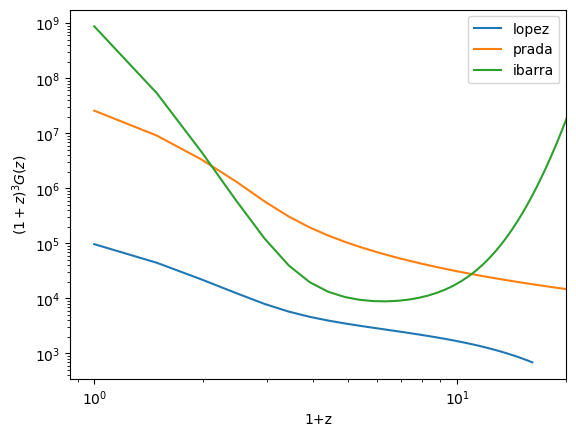

In [39]:
plt.plot((1+z),G_lopez(z)*(1+z)**3,label='lopez')
plt.plot((1+z),G_prada(z)*(1+z)**3,label='prada')
plt.plot((1+z),G_ibarra(z)*(1+z)**3,label='ibarra')
plt.legend()
plt.xlabel('1+z')
plt.ylabel(r'$(1+z)^3 G(z)$')
plt.yscale('log')
plt.xscale('log')
plt.xlim([0, 20])
plt.legend()

In [40]:
def dPhidE_extra(E, m_x, sv, G_function):
    z = m_x / E - 1  # To apply the delta function integral
    z_tmp = z[z > 0]

    Cosmos = (1 + G_function(z_tmp)) *(1 + z_tmp**3)/H_z(z_tmp)
    Physics = sv * (omega_dm * rho_c) ** 2
    factor = 8 * np.pi * m_x**2
    
    res = 2* Cosmos * Physics / (3 * E[E<m_x] *factor)
    
    result = np.zeros_like(E)
    result[0:len(res)] = res
    
    return result
#try different method

In [41]:
def dPhidE_extra_test(E, m_x, sv, G_function):
    z = m_x / E - 1  # To apply the delta function integral
    E_1= E*(1+z)
    z_tmp = z[z > 0]

    Cosmos = ((1+G_function(z_tmp)) * (1+z_tmp)**3)/H_z(z_tmp)
    Physics = sv * (rho_c*omega_m)**2 / (2 * m_x**2)
    
    res= 2 * 4* np.pi * Cosmos*Physics/ (E_1[E<m_x])
    
    result = np.zeros_like(E)
    result[0:len(res)] = res
    
    return result
#try different method

/tmp/ipykernel_14847/1090215601.py:3: RuntimeWarning: overflow encountered in power
  return ((c_200**3) * (1 - (1 + c_200)**(-3))) / (3 * (np.log(1 + c_200) - c_200 * (1 + c_200)**(-1))**2)
/tmp/ipykernel_14847/1931249293.py:7: RuntimeWarning: invalid value encountered in multiply
  return dln_inv_dlogM_lopez(M) * f_delta(sigma_final_lopez,M,z) * g_tild(M, z,c_200_lopez)
/tmp/ipykernel_14847/2075404716.py:15: RuntimeWarning: overflow encountered in exp
  return A * ((quote / b)**c + 1) * np.exp(d / quote**2)
/tmp/ipykernel_14847/1090215601.py:3: RuntimeWarning: invalid value encountered in multiply
  return ((c_200**3) * (1 - (1 + c_200)**(-3))) / (3 * (np.log(1 + c_200) - c_200 * (1 + c_200)**(-1))**2)
/tmp/ipykernel_14847/1931249293.py:21: RuntimeWarning: invalid value encountered in multiply
  return dln_inv_dlogM_prada(M) * f_delta(sigma_final_prada,M,z) * g_tild(M, z,c_200_prada)
/tmp/ipykernel_14847/2075404716.py:7: RuntimeWarning: overflow encountered in exp
  return A * ((quot

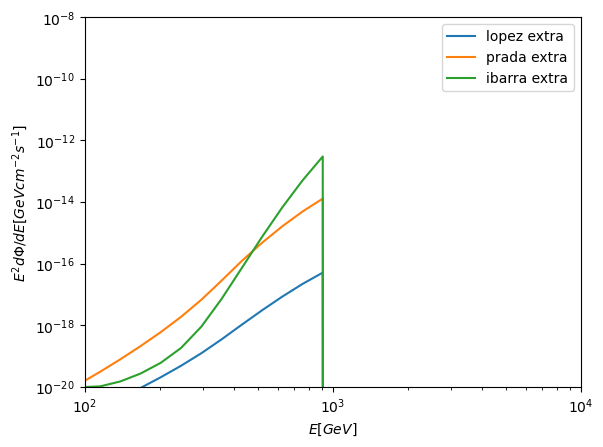

In [42]:
sv=1e-25
m_x=1000
E_log_grid=np.logspace(1, 5, 50)

plt.plot(E_log_grid,dPhidE_extra_test(E_log_grid,m_x,sv,G_lopez)*(E_log_grid**2),label='lopez extra')
plt.plot(E_log_grid,dPhidE_extra_test(E_log_grid,m_x,sv,G_prada)*(E_log_grid**2),label='prada extra')
plt.plot(E_log_grid,dPhidE_extra_test(E_log_grid,m_x,sv,G_ibarra)*(E_log_grid**2),label='ibarra extra')
plt.xlabel('$E[GeV]$')
plt.ylabel(r'$E^2 d\Phi/dE [GeV cm^{-2} s^{-1}]$')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e2,1e4])
plt.ylim([1e-20, 1e-8])
plt.legend()

### compare galactic and extragalactic contribution ###

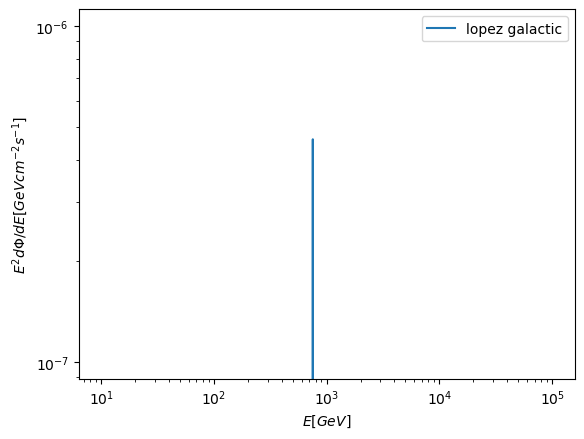

In [43]:
sv=1e-25
m_x=1000
E_log_grid=np.logspace(1, 5, 50)

plt.plot(E_log_grid,galactic_flux(E_log_grid,m_x,sv,J_allsky)*(E_log_grid**2),label='lopez galactic')
plt.xlabel('$E[GeV]$')
plt.ylabel(r'$E^2 d\Phi/dE [GeV cm^{-2} s^{-1}]$')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e-5,1e15])
#plt.ylim([0, 0.5e8])
plt.legend()